In [2]:
import random
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso

from dgp.scm import SimpleSCM

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Causal Secrets Mini-Course
## Secret 1 - Lecture 3

This notebook is a part of the [Causal Secrets Mini-Course](https://causalsecrets.com/).

<a href="https://causalpython.io"><img src="img/CausalPython.io - Dark.png" width=200 align="left"></a>

In [161]:
def sort_pairs(x, y):
    sorted_ids = np.argsort(x)
    return x[sorted_ids], y[sorted_ids]

In [265]:
class SimpleSCM2:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.norm(scale=2)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u_w = stats.norm(scale=2)
        self.u_q = stats.norm(scale=2)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u_w = self.u_w.rvs(sample_size)
        u_q = self.u_q.rvs(sample_size)
        
        if treatment_value:
            x = np.array([treatment_value]*sample_size)
        else:
            x = u_x + u_z + u_q
          
        z = u_z
        q = u_q
        y = -2*x + 8*z + 0.5*u_y + 5*q
        w = -2*x - 18*y + 0.2*u_w
        
        return x, y, z, w, q
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [273]:
# Instantiate the SCM (this object will generate the data for us)
scm = SimpleSCM2(random_seed=23)

In [274]:
# Sample data from the SCM (observations)
x, y, z, w, q = scm.sample(1000)

# Sample experimental data from the SCM (interventions/RCT)
x_rct = np.array([])
y_rct = np.array([])
z_rct = np.array([])
w_rct = np.array([])
q_rct = np.array([])

for i in np.arange(-10, 10, 0.2):
    x_rct_local, y_rct_local, z_rct_local, w_rct_local, q_rct_local = scm.intervene(
        i + random.gauss(mu=0, sigma=1), # Add variability to the treatment to de-quantize
        sample_size=10
    )
    x_rct = np.concatenate([x_rct, x_rct_local])
    y_rct = np.concatenate([y_rct, y_rct_local])
    z_rct = np.concatenate([z_rct, z_rct_local])
    w_rct = np.concatenate([w_rct, w_rct_local])
    q_rct = np.concatenate([q_rct, q_rct_local])

In [340]:
X = np.vstack([x, z]).T
X_rct = np.vstack([x_rct, z_rct]).T

In [341]:
lr = Lasso()
lr.fit(X, y)

Lasso()

In [342]:
lr.coef_

array([0.51846254, 5.3854379 ])

In [343]:
pred_obs = lr.predict(X)
pred_rct = lr.predict(X_rct)

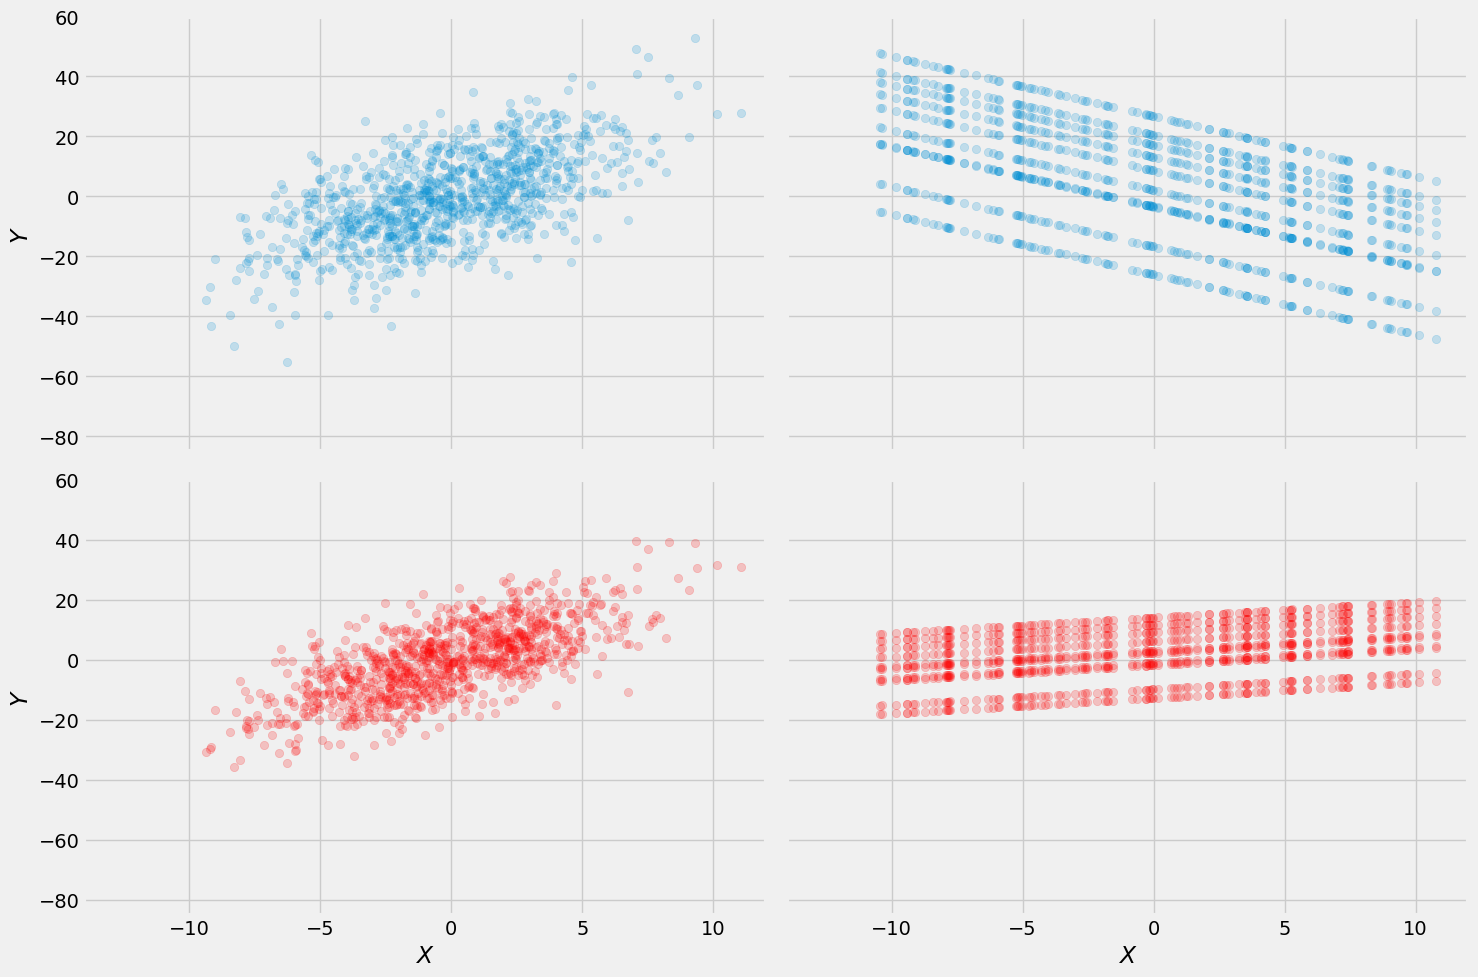

In [344]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.scatter(x, y, alpha=.2, label='Obs')
plt.xlim(-14, 12)
plt.ylim(-85, 60)
plt.tick_params(labelbottom=False)
plt.ylabel('$Y$')

plt.subplot(222)
plt.scatter(x_rct, y_rct, alpha=.2, label='Obs')
plt.xlim(-14, 12)
plt.ylim(-85, 60)
plt.tick_params(labelleft=False)
plt.tick_params(labelbottom=False)

plt.subplot(223)
plt.scatter(x, pred_obs, alpha=.2, c='r', label='Exp')
plt.xlim(-14, 12)
plt.ylim(-85, 60)
plt.ylabel('$Y$')
plt.xlabel('$X$')

plt.subplot(224)
plt.scatter(x_rct, pred_rct, alpha=.2, c='r', label='Exp')
plt.xlim(-14, 12)
plt.ylim(-85, 60)
plt.tick_params(labelleft=False)
plt.xlabel('$X$')

plt.tight_layout()